In [11]:
import numpy as np
import json
import time
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from pymoo.indicators.hv import Hypervolume

RISK_FREE_RATE = 0.05
FILE_PATH = r"D:\Lợi nhuận dương.json"
ALPHA = 0.9
steps = 50

In [12]:
# ============================================================================
# HYPERVOLUME FUNCTION
# ============================================================================
def calculate_hypervolume(pareto_front, reference_point):
    """
    Calculate the hypervolume of a Pareto front in 2D space.
    
    Parameters:
    pareto_front (list of tuples): List of points in the Pareto front [(x1, y1), (x2, y2), ...].
    reference_point (tuple): The reference point (x, y).
    
    Returns:
    float: The hypervolume.
    """
    # Sort the Pareto front by the first objective in descending order
    sorted_front = sorted(pareto_front, key=lambda x: x[0], reverse=True)
    
    # Initialize the hypervolume
    hypervolume = 0.0
    
    # Iterate over the points in the sorted Pareto front
    for i in range(len(sorted_front)):
        if i == 0:
            width = reference_point[0] - sorted_front[i][0]
        else:
            width = sorted_front[i-1][0] - sorted_front[i][0]
        height = reference_point[1] - sorted_front[i][1]
        hypervolume += width * height
    
    return hypervolume
def filter_pareto(points_positive):
    pareto_front = []

    for i, p in enumerate(points_positive):
        is_dominated = False
        for j, other in enumerate(points_positive):
            if i == j:
                continue
            if (
                (other[0] >= p[0] and other[1] >= p[1])
                and (other[0] > p[0] or other[1] > p[1])
            ):
                is_dominated = True
                break
        if not is_dominated:
            pareto_front.append(p)

    return np.array(pareto_front)

## Tam giác

In [13]:
# ============================================================================
# TRIANGULAR FUZZY NUMBER FUNCTIONS
# ============================================================================
def expected_tfn(fuzzy):
    return (fuzzy[0] + 4.0 * fuzzy[1] + fuzzy[2]) / 6.0

def variance_tfn(fuzzy):
    return (
        (fuzzy[1] - fuzzy[0]) ** 2
        + (fuzzy[2] - fuzzy[1]) ** 2
        + (fuzzy[1] - fuzzy[0]) * (fuzzy[2] - fuzzy[1])
    ) / 18.0

def value_at_risk_tfn(fuzzy, alpha=ALPHA):
    if alpha <= 0.5:
        return 2 * alpha * fuzzy[1] + (1 - 2 * alpha) * fuzzy[0]
    else:
        return (2 * alpha - 1) * fuzzy[2] + (2 - 2 * alpha) * fuzzy[1]

def sharpe_ratio_tfn(fuzzy, rf=RISK_FREE_RATE):
    var = variance_tfn(fuzzy)
    if var <= 1e-10:
        return 0.0
    return (expected_tfn(fuzzy) - rf) / var

def var_ratio_tfn(fuzzy, rf=RISK_FREE_RATE):
    var_val = value_at_risk_tfn(fuzzy)
    if abs(var_val) <= 1e-10:
        return 0.0
    return (expected_tfn(fuzzy) - rf) / var_val

def get_portfolio_tfn(weights, FPS):
    return (weights.reshape(-1, 1).T @ FPS).reshape(-1)


✅ Loaded 60 stocks.

⏱ Runtime:        0.87 seconds
📊 Pareto points: 100
💎 Hypervolume:   0.0126725024


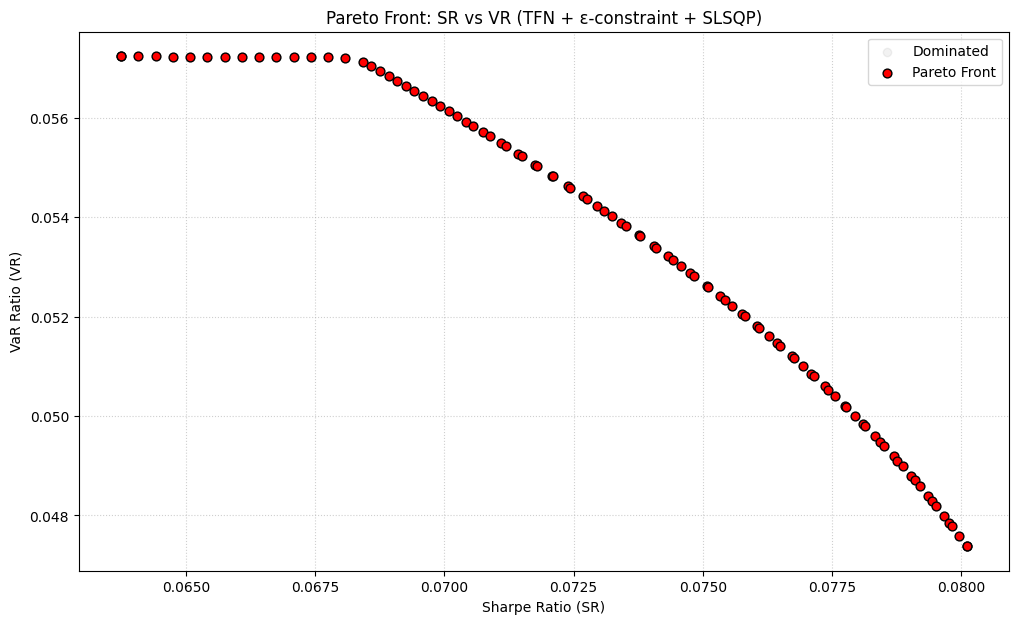

In [14]:
# ============================================================================
# MAIN PROGRAM
# ============================================================================
def main():

    # ------------------------------------------------------------------
    # 1. Load data
    # ------------------------------------------------------------------
    try:
        with open(FILE_PATH, "r", encoding="utf-8") as f:
            data = json.load(f)

        FPS = np.array([
            [v["triangular"]["a"], v["triangular"]["b"], v["triangular"]["c"]]
            for v in data.values()
        ])

        tickers = list(data.keys())
        print(f"✅ Loaded {len(tickers)} stocks.")

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return

    num_assets = len(tickers)
    x0 = np.ones(num_assets) / num_assets
    bounds = [(0, 1) for _ in range(num_assets)]
    base_cons = {"type": "eq", "fun": lambda x: np.sum(x) - 1}

    start_time = time.time()

    # ------------------------------------------------------------------
    # 2. Anchor points
    # ------------------------------------------------------------------
    res_sr = minimize(
        lambda x: -sharpe_ratio_tfn(get_portfolio_tfn(x, FPS)),
        x0, method="SLSQP", bounds=bounds, constraints=base_cons
    )

    res_vr = minimize(
        lambda x: -var_ratio_tfn(get_portfolio_tfn(x, FPS)),
        x0, method="SLSQP", bounds=bounds, constraints=base_cons
    )

    max_sr = -res_sr.fun
    max_vr = -res_vr.fun

    vr_at_max_sr = var_ratio_tfn(get_portfolio_tfn(res_sr.x, FPS))
    sr_at_max_vr = sharpe_ratio_tfn(get_portfolio_tfn(res_vr.x, FPS))

    # ------------------------------------------------------------------
    # 3. ε-constraint scan
    # ------------------------------------------------------------------
    results_negative = []

    # ---- Scan VR constraint (maximize SR | VR ≥ ε)
    curr_x = res_sr.x
    for ev in np.linspace(vr_at_max_sr, max_vr, steps):
        cons = [
            base_cons,
            {"type": "ineq",
             "fun": lambda x, ev=ev:
                 var_ratio_tfn(get_portfolio_tfn(x, FPS)) - ev}
        ]
        res = minimize(
            lambda x: -sharpe_ratio_tfn(get_portfolio_tfn(x, FPS)),
            curr_x, method="SLSQP", bounds=bounds, constraints=cons
        )
        if res.success:
            curr_x = res.x
            results_negative.append([
                -sharpe_ratio_tfn(get_portfolio_tfn(res.x, FPS)),
                -var_ratio_tfn(get_portfolio_tfn(res.x, FPS))
            ])

    # ---- Scan SR constraint (maximize VR | SR ≥ ε)
    curr_x = res_vr.x
    for es in np.linspace(sr_at_max_vr, max_sr, steps):
        cons = [
            base_cons,
            {"type": "ineq",
             "fun": lambda x, es=es:
                 sharpe_ratio_tfn(get_portfolio_tfn(x, FPS)) - es}
        ]
        res = minimize(
            lambda x: -var_ratio_tfn(get_portfolio_tfn(x, FPS)),
            curr_x, method="SLSQP", bounds=bounds, constraints=cons
        )
        if res.success:
            curr_x = res.x
            results_negative.append([
                -sharpe_ratio_tfn(get_portfolio_tfn(res.x, FPS)),
                -var_ratio_tfn(get_portfolio_tfn(res.x, FPS))
            ])

    results_negative = np.array(results_negative)

    # ------------------------------------------------------------------
    # 4. Post-processing
    # ------------------------------------------------------------------
    points_positive = -results_negative
    pareto_positive = filter_pareto(points_positive)
    pareto_positive = pareto_positive[pareto_positive[:, 0].argsort()]

    # ------------------------------------------------------------------
    # 5. Hypervolume (MAX–MAX)
    # ------------------------------------------------------------------
    objectives = pareto_positive

    margin = 0.1
    ref_point = [
        np.max(objectives[:, 0]) + margin,
        np.max(objectives[:, 1]) + margin
    ]

    hv_value = calculate_hypervolume(objectives, ref_point)
    duration = time.time() - start_time

    # ------------------------------------------------------------------
    # 6. Output
    # ------------------------------------------------------------------
    print("\n" + "=" * 45)
    print(f"⏱ Runtime:        {duration:.2f} seconds")
    print(f"📊 Pareto points: {len(pareto_positive)}")
    print(f"💎 Hypervolume:   {hv_value:.10f}")
    print("=" * 45)

    plt.figure(figsize=(12, 7))
    plt.scatter(
        points_positive[:, 0], points_positive[:, 1],
        c="gray", alpha=0.1, label="Dominated"
    )
    plt.scatter(
        pareto_positive[:, 0], pareto_positive[:, 1],
        c="red", s=40, edgecolors="black",
        label="Pareto Front", zorder=3
    )
    plt.xlabel("Sharpe Ratio (SR)")
    plt.ylabel("VaR Ratio (VR)")
    plt.title("Pareto Front: SR vs VR (TFN + ε-constraint + SLSQP)")
    plt.legend()
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.show()


if __name__ == "__main__":
    main()


## Hình Thang

In [15]:
def load_data(file_path):
    """Đọc dữ liệu số mờ hình thang (trapezoidal fuzzy numbers) từ file JSON"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    trapezoidal_fuzzy_numbers_list = []
    tickers = []

    for ticker, stock_data in data.items():
        trap_params = stock_data['trapezoidal']
        trapezoidal_fuzzy_numbers_list.append([
            trap_params['a'],
            trap_params['b'],
            trap_params['c'],
            trap_params['d']
        ])
        tickers.append(ticker)

    TFPS = np.array(trapezoidal_fuzzy_numbers_list)
    print(f"✅ Đã tải dữ liệu: {len(tickers)} cổ phiếu (TRFN)")

    return TFPS, tickers

In [16]:

def expected_trfn(fuzzy):
    return (fuzzy[0] + 2. * fuzzy[1] + 2. * fuzzy[2] + fuzzy[3]) / 6.

def variance_trfn(fuzzy):
    return (np.power(fuzzy[1] + fuzzy[3] - fuzzy[0] - fuzzy[2], 2) + 6. * np.power(fuzzy[1] - fuzzy[2], 2) - 4. * (fuzzy[1] - fuzzy[2]) * (fuzzy[1] + fuzzy[3] - fuzzy[0] - fuzzy[2])) / 24

def value_at_risk_trfn(fuzzy):
    alpha = 0.9
    if alpha <= 0.5:
        return 2 * alpha * fuzzy[1] + (1 - 2 * alpha) * fuzzy[0]
    else:
        return (2 * alpha - 1) * fuzzy[3] + (2 - 2 * alpha) * fuzzy[2]
    
def VR_trfn(fuzzy):
    return (expected_trfn(fuzzy) - 0.05) / value_at_risk_trfn(fuzzy)

def SR_trfn(fuzzy):
    return (expected_trfn(fuzzy) - 0.05) / variance_trfn(fuzzy)

def SR(X):
    return SR_trfn((X.reshape(-1, 1).T @ TFPS).reshape(-1))

def VR(X):
    return VR_trfn((X.reshape(-1, 1).T @ TFPS).reshape(-1))

✅ Loaded 60 stocks.

⏱ Runtime:        0.97 seconds
📊 Pareto points: 99
💎 Hypervolume:   0.0111747253


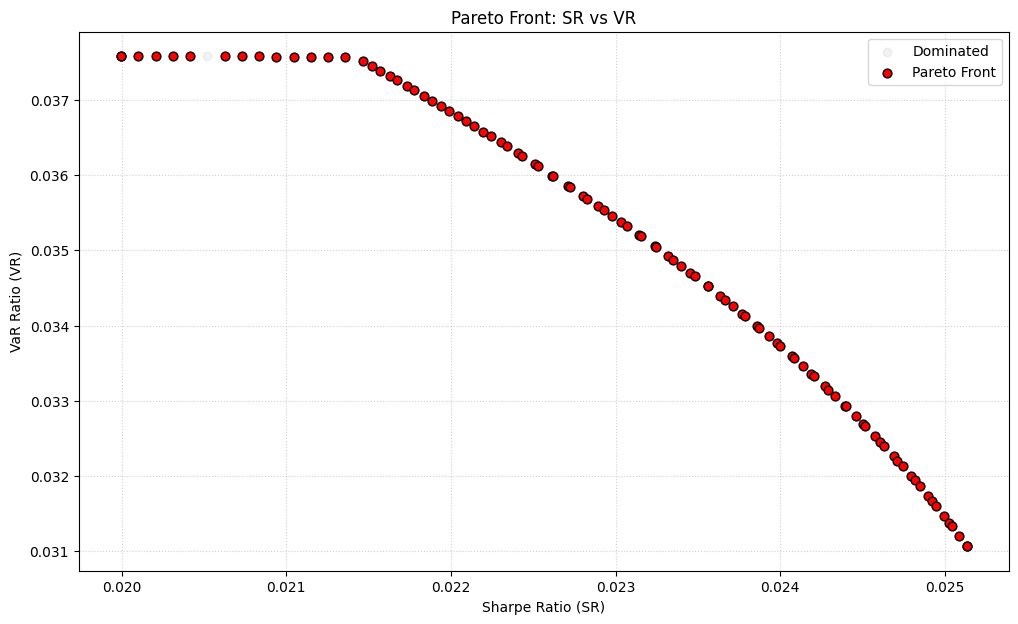

In [17]:
# ============================================================================
# MAIN PROGRAM
# ============================================================================
def main():
    global TFPS

    # ============================================================
    # 1. Load data
    # ============================================================
    try:
        with open(FILE_PATH, "r", encoding="utf-8") as f:
            data = json.load(f)

        TFPS = np.array([
            [
                v["trapezoidal"]["a"],
                v["trapezoidal"]["b"],
                v["trapezoidal"]["c"],
                v["trapezoidal"]["d"]
            ]
            for v in data.values()
        ])

        tickers = list(data.keys())
        print(f"✅ Loaded {len(tickers)} stocks.")

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return

    num_assets = len(tickers)
    x0 = np.ones(num_assets) / num_assets
    bounds = [(0, 1)] * num_assets
    base_cons = {"type": "eq", "fun": lambda x: np.sum(x) - 1}

    start_time = time.time()

    # ============================================================
    # 2. Anchor points
    # ============================================================
    res_sr = minimize(
        lambda x: -SR(x),
        x0,
        method="SLSQP",
        bounds=bounds,
        constraints=base_cons
    )

    res_vr = minimize(
        lambda x: -VR(x),
        x0,
        method="SLSQP",
        bounds=bounds,
        constraints=base_cons
    )

    max_sr = SR(res_sr.x)
    max_vr = VR(res_vr.x)

    vr_at_max_sr = VR(res_sr.x)
    sr_at_max_vr = SR(res_vr.x)

    # ============================================================
    # 3. ε-constraint scan
    # ============================================================
    results_negative = []

    # ---- Scan VR constraint (maximize SR) ----
    curr_x = res_sr.x
    for ev in np.linspace(vr_at_max_sr, max_vr, steps):

        cons = [
            base_cons,
            {"type": "ineq", "fun": lambda x, ev=ev: VR(x) - ev}
        ]

        res = minimize(
            lambda x: -SR(x),
            curr_x,
            method="SLSQP",
            bounds=bounds,
            constraints=cons
        )

        if res.success:
            curr_x = res.x
            results_negative.append([
                -SR(res.x),
                -VR(res.x)
            ])

    # ---- Scan SR constraint (maximize VR) ----
    curr_x = res_vr.x
    for es in np.linspace(sr_at_max_vr, max_sr, steps):

        cons = [
            base_cons,
            {"type": "ineq", "fun": lambda x, es=es: SR(x) - es}
        ]

        res = minimize(
            lambda x: -VR(x),
            curr_x,
            method="SLSQP",
            bounds=bounds,
            constraints=cons
        )

        if res.success:
            curr_x = res.x
            results_negative.append([
                -SR(res.x),
                -VR(res.x)
            ])

    results_negative = np.array(results_negative)

    # ============================================================
    # 4. Pareto + Hypervolume
    # ============================================================
    points_positive = -results_negative
    pareto_positive = filter_pareto(points_positive)
    pareto_positive = pareto_positive[pareto_positive[:, 0].argsort()]

    margin = 0.1
    ref_point = [
        np.max(pareto_positive[:, 0]) + margin,
        np.max(pareto_positive[:, 1]) + margin
    ]

    hv_value = calculate_hypervolume(pareto_positive, ref_point)
    duration = time.time() - start_time

    # ============================================================
    # 5. Output
    # ============================================================
    print("\n" + "=" * 45)
    print(f"⏱ Runtime:        {duration:.2f} seconds")
    print(f"📊 Pareto points: {len(pareto_positive)}")
    print(f"💎 Hypervolume:   {hv_value:.10f}")
    print("=" * 45)

    plt.figure(figsize=(12, 7))
    plt.scatter(
        points_positive[:, 0],
        points_positive[:, 1],
        c="gray",
        alpha=0.1,
        label="Dominated"
    )
    plt.scatter(
        pareto_positive[:, 0],
        pareto_positive[:, 1],
        c="red",
        s=40,
        edgecolors="black",
        label="Pareto Front",
        zorder=3
    )
    plt.xlabel("Sharpe Ratio (SR)")
    plt.ylabel("VaR Ratio (VR)")
    plt.title("Pareto Front: SR vs VR")
    plt.legend()
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.show()


if __name__ == "__main__":
    main()


## Gaussian

In [18]:
def load_data_gaussian(file_path):
    """Đọc dữ liệu số mờ Gaussian từ file JSON"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    gaussian_fuzzy_numbers_list = []
    tickers = []

    for ticker, stock_data in data.items():
        gauss_params = stock_data['gaussian']
        gaussian_fuzzy_numbers_list.append([
            gauss_params['center'],
            gauss_params['sigma']
        ])
        tickers.append(ticker)

    GFPS = np.array(gaussian_fuzzy_numbers_list)
    print(f"✅ Đã tải dữ liệu: {len(tickers)} cổ phiếu (Gaussian)")

    return GFPS, tickers


In [19]:

def expected_efn(fuzzy):
    return (np.sqrt(6) * fuzzy * np.log(2)) / np.pi

def variance_efn(fuzzy):
    return 2.0031 * np.power(fuzzy, 2)

def value_at_risk_efn(fuzzy):
    alpha = 0.9
    return np.max([(np.log(alpha) - np.log(1 - alpha)) * np.sqrt(6) * fuzzy / np.pi, np.zeros_like(fuzzy)], axis=0)
    
def VR_efn(fuzzy):
    return (expected_efn(fuzzy) - 0.05) / value_at_risk_efn(fuzzy).reshape(-1)

def SR_efn(fuzzy):
    return (expected_efn(fuzzy) - 0.05) / variance_efn(fuzzy)

def SR(X):
    return SR_efn(X.reshape(-1, 1).T @ EFPS).reshape(-1)

def VR(X):
    return VR_efn(X.reshape(-1, 1).T @ EFPS).reshape(-1)

✅ Loaded 60 stocks.

⏱ Runtime:        1.05 seconds
📊 Pareto points: 100
💎 Hypervolume:   0.0161806736


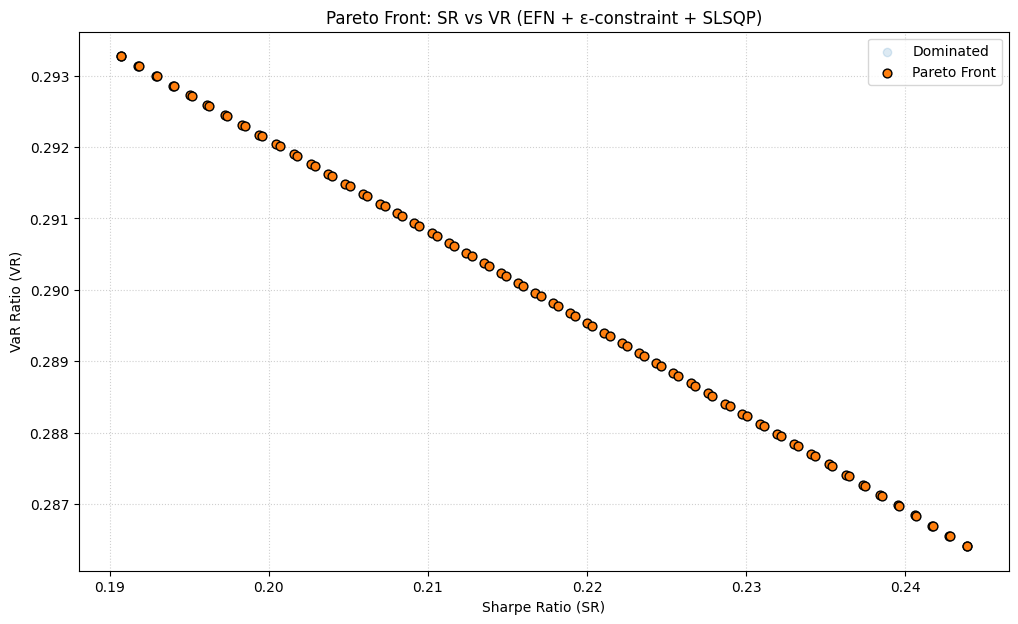

In [20]:
# ============================================================================
# MAIN PROGRAM (EFN PIPELINE – FIXED & STABLE)
# ============================================================================
def main():

    # 1. Load data
    try:
        with open(FILE_PATH, "r", encoding="utf-8") as f:
            data = json.load(f)

        xi = np.array([v["gaussian"]["center"] for v in data.values()])
        global EFPS
        EFPS = np.exp(xi.reshape(-1, 1))

        tickers = list(data.keys())
        print(f"✅ Loaded {len(tickers)} stocks.")

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return

    num_assets = len(tickers)
    x0 = np.ones(num_assets) / num_assets
    bounds = [(0, 1) for _ in range(num_assets)]
    base_cons = {"type": "eq", "fun": lambda x: np.sum(x) - 1}

    start_time = time.time()

    # ------------------------------------------------------------------
    # 2. Anchor points
    # ------------------------------------------------------------------
    res_sr = minimize(
        lambda x: -SR(x),
        x0, method="SLSQP", bounds=bounds, constraints=base_cons
    )

    res_vr = minimize(
        lambda x: -VR(x),
        x0, method="SLSQP", bounds=bounds, constraints=base_cons
    )

    max_sr = SR(res_sr.x).item()
    max_vr = VR(res_vr.x).item()

    sr_at_max_vr = SR(res_vr.x).item()
    vr_at_max_sr = VR(res_sr.x).item()

    # ------------------------------------------------------------------
    # 3. ε-constraint scan
    # ------------------------------------------------------------------
    results_negative = []

    # ---- Scan VR constraint (maximize SR | VR >= ε)
    curr_x = res_sr.x
    for ev in np.linspace(vr_at_max_sr, max_vr, steps):
        cons = [
            base_cons,
            {"type": "ineq", "fun": lambda x, ev=ev: VR(x) - ev}
        ]
        res = minimize(
            lambda x: -SR(x),
            curr_x, method="SLSQP", bounds=bounds, constraints=cons
        )
        if res.success:
            curr_x = res.x
            results_negative.append([
                -SR(res.x).item(),
                -VR(res.x).item()
            ])

    # ---- Scan SR constraint (maximize VR | SR >= ε)
    curr_x = res_vr.x
    for es in np.linspace(sr_at_max_vr, max_sr, steps):
        cons = [
            base_cons,
            {"type": "ineq", "fun": lambda x, es=es: SR(x) - es}
        ]
        res = minimize(
            lambda x: -VR(x),
            curr_x, method="SLSQP", bounds=bounds, constraints=cons
        )
        if res.success:
            curr_x = res.x
            results_negative.append([
                -SR(res.x).item(),
                -VR(res.x).item()
            ])

    results_negative = np.array(results_negative, dtype=float)

    # ------------------------------------------------------------------
    # 4. Post-processing
    # ------------------------------------------------------------------
    points_positive = -results_negative
    pareto_positive = filter_pareto(points_positive)
    pareto_positive = pareto_positive[pareto_positive[:, 0].argsort()]

    # ------------------------------------------------------------------
    # 5. Hypervolume (MAX–MAX)
    # ------------------------------------------------------------------
    objectives = pareto_positive

    margin = 0.1
    ref_point = [
        np.max(objectives[:, 0]) + margin,
        np.max(objectives[:, 1]) + margin
    ]

    hv_value = calculate_hypervolume(objectives, ref_point)
    duration = time.time() - start_time

    # ------------------------------------------------------------------
    # 6. Output
    # ------------------------------------------------------------------
    print("\n" + "=" * 45)
    print(f"⏱ Runtime:        {duration:.2f} seconds")
    print(f"📊 Pareto points: {len(pareto_positive)}")
    print(f"💎 Hypervolume:   {hv_value:.10f}")
    print("=" * 45)

    plt.figure(figsize=(12, 7))
    plt.scatter(
        points_positive[:, 0], points_positive[:, 1],
        alpha=0.15, label="Dominated"
    )
    plt.scatter(
        pareto_positive[:, 0], pareto_positive[:, 1],
        s=40, edgecolors="black", label="Pareto Front", zorder=3
    )
    plt.xlabel("Sharpe Ratio (SR)")
    plt.ylabel("VaR Ratio (VR)")
    plt.title("Pareto Front: SR vs VR (EFN + ε-constraint + SLSQP)")
    plt.legend()
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.show()


if __name__ == "__main__":
    main()
